<hr style="height:2px;">

# Demo: Training data generation for denoising with Noise2Noise
This notebook demonstrates training data generation for a 3D denoising task, where corresponding pairs of low and high quality stacks can be acquired. 

Each pair should be registered, which is best achieved by acquiring both stacks _interleaved_, i.e. as different channels that correspond to the different exposure/laser settings. 

This will use EM data and will try to denoise from imput noisy images and output noisy images as GT.

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, plot_some
from csbdeep.data import RawData, create_patches

<hr style="height:2px;">

# Load example data

We can plot the training stack pair via maximum-projection:

In [23]:
from tifffile import imread, imwrite
data = imread('./data/SEM/train/train.tif').astype(np.float32)

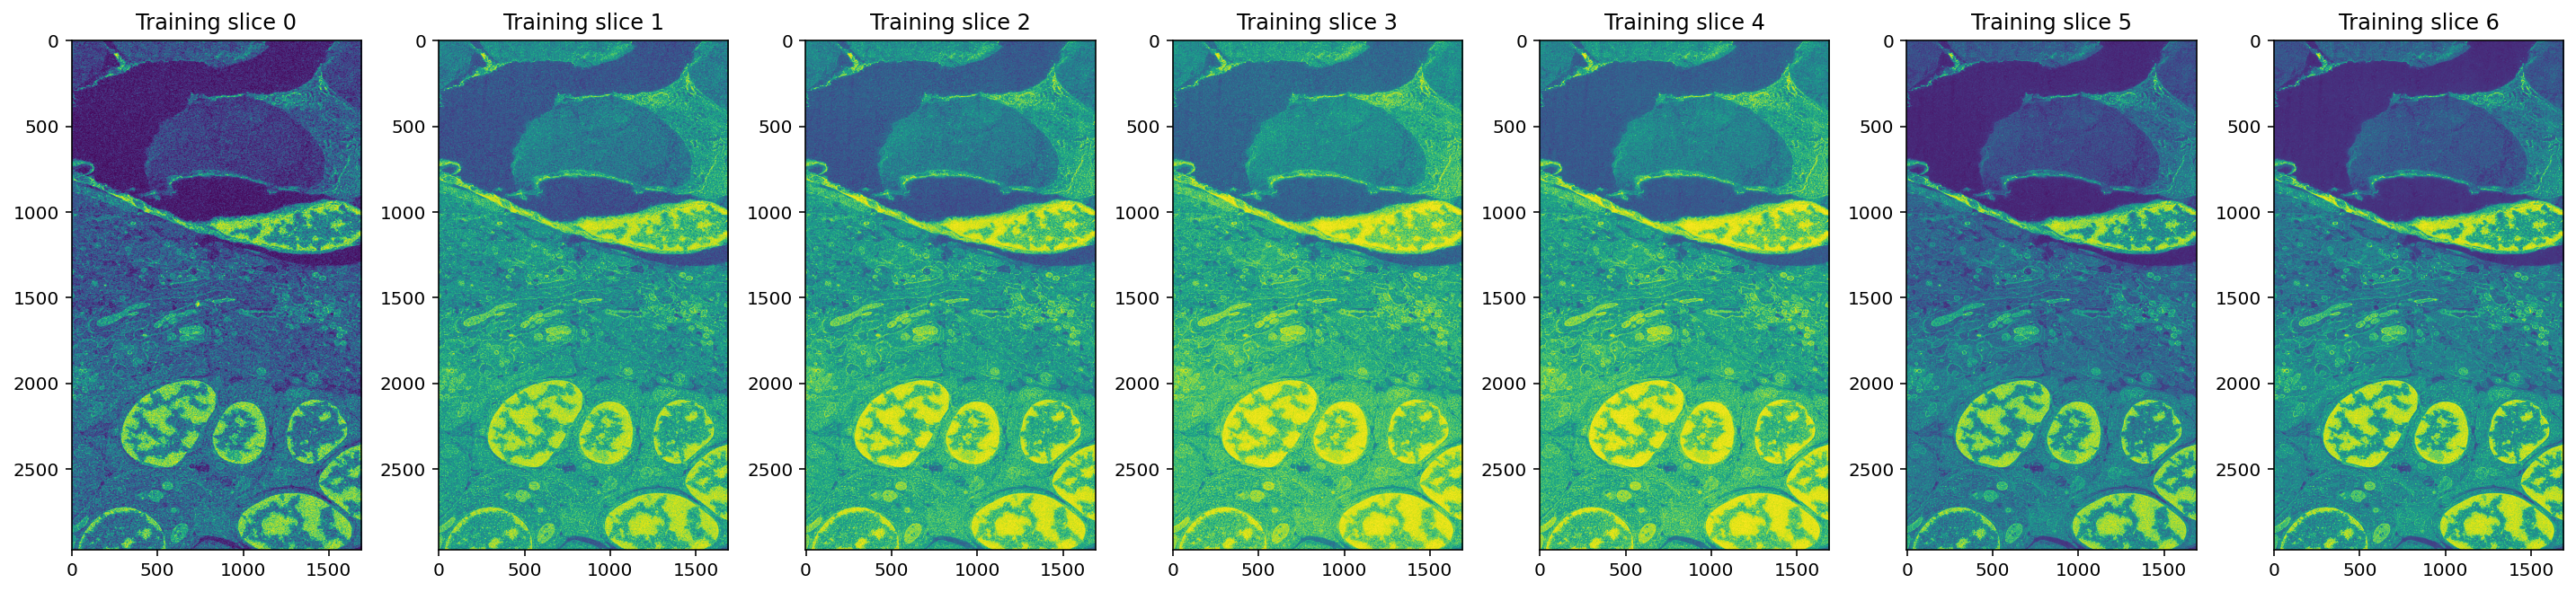

In [24]:
# Images 2 and 3 were recorded with 1 microsecond of exposure time both, so they will be the train and GT
fig, axs = plt.subplots(1,data.shape[0], figsize=(20,20))
for i,ax in zip(range(0,data.shape[0]),axs.flatten()):
    ax.imshow(data[i])
    ax.set_title('Training slice {}'.format(i))
plt.tight_layout()
plt.show()

In [25]:
# Write the needed images to separate folders with identical filenames
import os

base = 'train'
out = os.path.join('./', base)
cats = ['low','GT']
img_idxs = [2,3]

for idx,cat in zip(img_idxs, cats):
    fdir = os.path.join(out, cat)
    os.makedirs(fdir)
    fname = os.path.join(fdir, 'ntn_image.tif')
    imwrite(fname,data[idx])

<hr style="height:2px;">

# Generate training data for CARE

We first need to create a `RawData` object, which defines how to get the pairs of low/low SNR stacks and the semantics of each axis (e.g. which one is considered a color channel, etc.).

Here we have two folders "low" and "GT", where corresponding low and low-SNR stacks are TIFF images with identical filenames generated from previous cell.  
For this case, we can simply use `RawData.from_folder` and set `axes = 'YX'` (two dimensional) to indicate the semantic order of the image axes. 

In [26]:
raw_data = RawData.from_folder (
    basepath    = 'train/',
    source_dirs = ['low'],
    target_dir  = 'GT',
    axes        = 'YX',
)

In [27]:
raw_data

RawData(generator=<function RawData.from_folder.<locals>._gen at 0x7f80f27d7e60>, size=1, description="train/: target='GT', sources=['low'], axes='YX', pattern='*.tif*'")

From corresponding stacks, we now generate some 2D patches. As a general rule, use a patch size that is a power of two along XYZT, or at least divisible by 8.  
Typically, you should use more patches the more trainings stacks you have. By default, patches are sampled from non-background regions (i.e. that are above a relative threshold), see the documentation of `create_patches` for details.

Note that returned values `(X, Y, XY_axes)` by `create_patches` are not to be confused with the image axes X and Y.  
By convention, the variable name `X` (or `x`) refers to an input variable for a machine learning model, whereas `Y` (or `y`) indicates an output variable.

In [29]:
X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (64,64),
    n_patches_per_image = 1024,
    save_file           = 'train/my_training_data_n2n.npz',
)

    1 raw images x    1 transformations   =     1 images
    1 images     x 1024 patches per image =  1024 patches in total
Input data:
train/: target='GT', sources=['low'], axes='YX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
64 x 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]

Saving data to train/my_training_data_n2n.npz.


In [30]:
assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", XY_axes)

shape of X,Y = (1024, 1, 64, 64)
axes  of X,Y = SCYX


## Show

This shows the maximum projection of some of the generated patch pairs (odd rows: *source*, even rows: *target*). Since we are doing Noise2Noise, these will eventually look pretty similar as opposed to how they were looking before in the usual CARE.

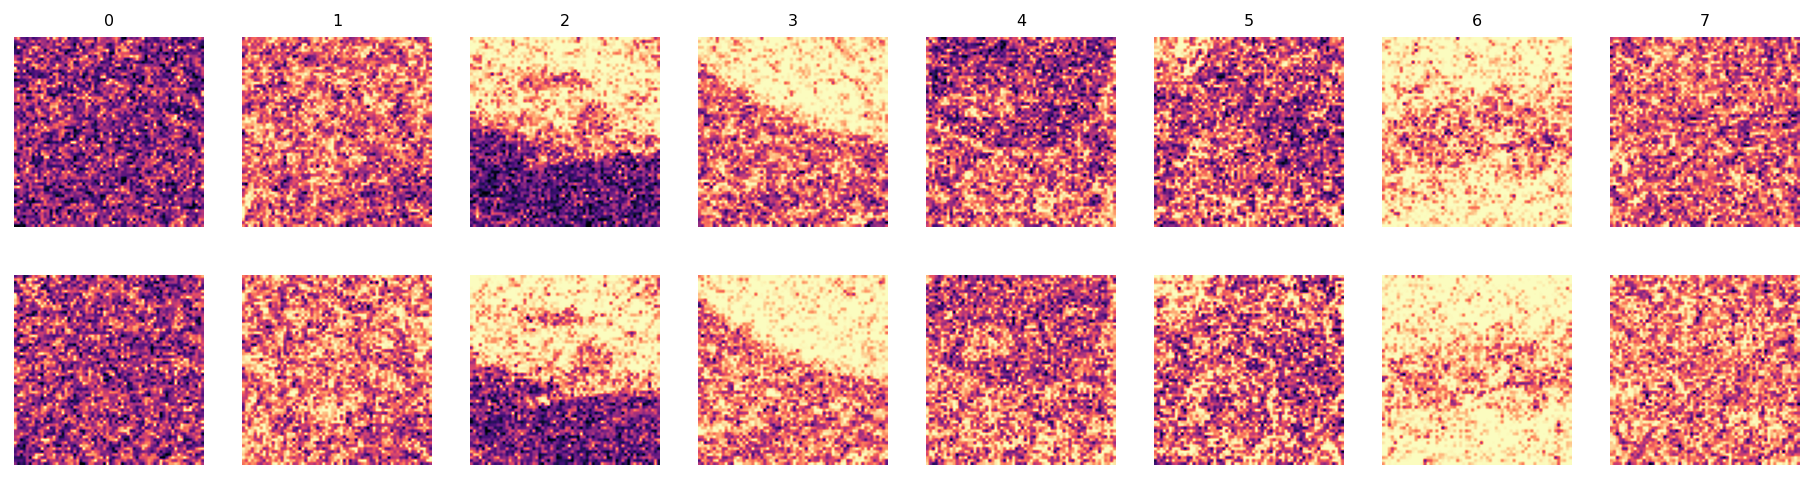

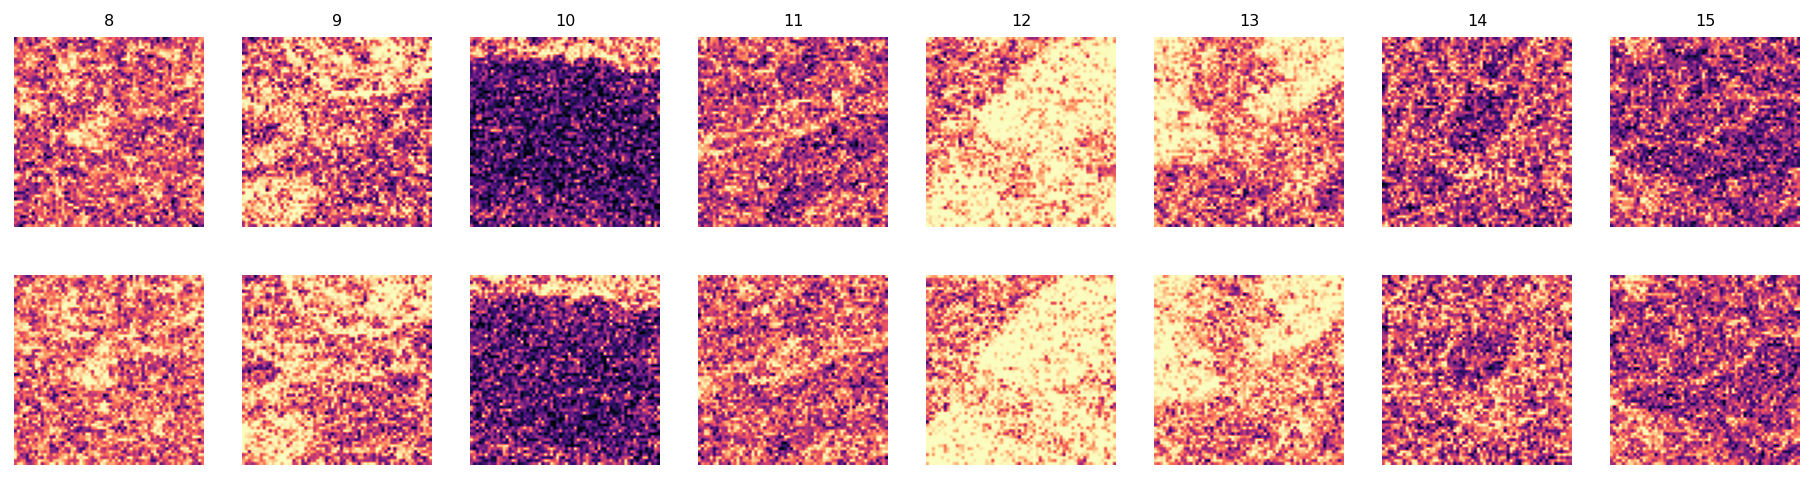

In [31]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;